<h2 align="center"> Logistic Regression </h2>

### Task 1: Load the Data and Libraries
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.style.use("ggplot")
%matplotlib inline

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

Unlike in the case of linear regression, where we're trying to predict a real and continuous valued output, logistic regression is a classification algorithm and it tries to predict a discrete set of class labels for the given input.

Our dataset is __DMV_Written_Tests.csv__. This dataset is comprised of written test scores. We will be trying to predict if a person with those test scores passed or failed. This dataset contains scores for two written test at the DMV. It also contains the result.

In [3]:
data = pd.read_csv("DMV_Written_Tests.csv")
data.head()

,DMV_Test_1,DMV_Test_2,Results
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


Our dataframe has 3 coulmns. The first and second columns are the test scores taken by the individual. The third column contains a binary class label. Zero(0) if the person failed or One(1) if the person passed.

Our goal is to use logistic regressions to learn from this data and predict the result based on any given test scores.

Let's use info() to get some more insights into this particular dataset.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DMV_Test_1  100 non-null    float64
 1   DMV_Test_2  100 non-null    float64
 2   Results     100 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 2.5 KB


Here we can see that our dataset is pretty small and it contains 100 entries. Meaning that it has a set of 100 test scores and result. It also has 3 columns.

To make this dataset easier to work with, let's separate our features which are the test scores from the target.

In [5]:
# create variable to store our score features
scores = data[['DMV_Test_1', 'DMV_Test_2']].values #we don't want the entire dataframe, just the values

# create variable to store our result features
results = data['Results'].values

Perform data visualiztion before implementing our logistic regression model.

### Task 2: Visualize the Data
---

It is best practice to visualize the data before making a choice of learning algorithm and implementing it. Our objective is to classify the data as passed or failed based on the test scores. To do so we need to ensure that we have good separability between the passed and the failed class.

Also, a point to keep in mind is that our decision boundary to logistic regression is gonna be linear. It's either straight line or linear hyperplane.

So what are looking for is linear separability in our data to be able to achieve good results from our model.

In this task, let'create a scatterplot of our data and then color the points based on our class label. That is the points that have passed are in one color and points that have failed are in contrasting color.

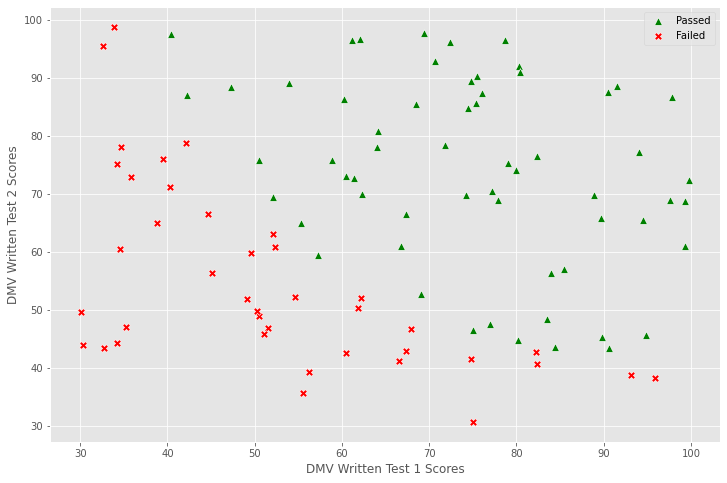

In [6]:
# create two column vectors
passed = (results == 1).reshape(100, 1) #this is a vector of 100 rows and 1 column.
failed = (results == 0).reshape(100, 1)

# use seaborn to create a scatterplot and plot them separately
ax = sns.scatterplot(x = scores[passed[:, 0], 0],
                     y = scores[passed[:, 0], 1],
                     marker = "^", # use triangle for this plot
                     color = 'green', # color of the passed points
                     s=60) # size of each point
sns.scatterplot(x = scores[failed[:, 0], 0],
                y = scores[failed[:, 0], 1],
                marker = "X",
                color = 'red',
                s=60)
# set the label for x and y axes and create a legend
ax.set(xlabel='DMV Written Test 1 Scores', ylabel = 'DMV Written Test 2 Scores')
ax.legend(['Passed', 'Failed'])
plt.show();

People with higher scores in both of the tests, in the region of green triangle, are classified as passed.

What our logistic regression model did is output a linear decision boundary or hyperplane where all the points on one side of the plane are classfied as passed and the other point point on the other side are classified as failed.

The decision boundary is gonna be defined as "*the set of x for which the probability of belonging to the class passed or failed is exactly one half (1/2)*". A function that models this really well is called the __[Logistic Sigmoid Function](https://en.wikipedia.org/wiki/Sigmoid_function)__ or just __Sigmoid__.

### Task 3: Define the Logistic Sigmoid Function $\sigma(z)$
---

$$ \sigma(z) = \frac{1}{1+e^{-z}}$$

The above formula is the logistic sigmoid function. This is exactly  where the learning algorithm gets its name from. What's awesome about this function is that we can interpret the output as a probability. So since this function outputs in the range 0 to 1, that can be interpeted as a probability for any input. We can threshold the function as 0.5 or 50% to make our classification.

That is if the output of the function here is greater than or equal to 0.5, we can classify the sample as a positive sample. Or in our data, the person passed. And if its less than 0.5, we can classify it as failed. 

The maximal uncertainty of "1" in  arises when we plug the input zero.
So __e to the negative zero__ is just 1, __one plus one__ is two, __one over two__ is 0.5.

What it's telling us is that a particular datapoint has a 50% probability of being in one class and a 50% probabilty being in other class. Meaning that our algorithm is maximally uncertain about that point.

Now let's use this function to make predictions based on the inupt.
Our inputs will be the *z* value here; we'll plug in the "1 + e" formula; if our values occuring 0.5, we'll classify that input as being in the class passed.

In [7]:
# let's define a function
# let's name it logistic function
def logistic_function(x): # this just takes one input (x).
    return 1 / (1 + np.exp(-x)) # we used numpy to get the 
                                # exponential function (e to the negative z) 
                                # raised to the negative of the input.

In [8]:
# Let's test it in the input zero.
# We know from the formula above that 
# we're supposed to get an output of 0.5.
logistic_function(0)

0.5

Great! It's working as expected.

### Task 4: Compute the Cost Function $J(\theta)$ and Gradient
---

The objective of logistic regression is to minimize the cost function

$$J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} [ y^{(i)}log(h_{\theta}(x^{(i)})) + (1 - y^{(i)})log(1 - (h_{\theta}(x^{(i)}))]$$

where the gradient of the cost function is given by

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_{\theta}(x^{(i)}) - y^{(i)})x_j^{(i)}$$

In [9]:
def compute_cost(theta, x, y):
    m = len(y)
    y_pred = logistic_function(np.dot(x, theta))
    error = (y * np.log(y_pred)) + (1 - y) * np.log(1 - y_pred)
    cost = - 1 / m * sum(error)
    gradient = 1 / m * np.dot(x.transpose(), (y_pred - y))
    return cost[0], gradient    

### Task 5: Cost and Gradient at Initialization
---

In this task, let's compute the cost and look at the gradient when we have initialized our parameter theta to just be all zero. We're not performing optimization yet.

Before we can compute the cost and gradient for our data, it's best pratcie before doing any gradient descent to perform data standardization so that the difference scale of our various features dont adversely biased our models towards incorrect results. 

In [10]:
# compute the mean and standard deviation for our test scores
mean_scores = np.mean(scores, axis=0)
std_scores = np.std(scores, axis =0)
# subtract the mean from the scores and divide the result by std
scores = (scores - mean_scores) / std_scores

rows = scores.shape[0]
cols = scores.shape[1]

# create our feature matrix X
X = np.append(np.ones((rows, 1)), scores, axis=1)
# create our target vector
y = results.reshape(rows, 1)

# initalize our theta values
theta_init = np.zeros((cols + 1, 1))
# compute the cost and the gradient
cost, gradient = compute_cost(theta_init, X, y)

print("Cost at initialization", cost)
print("Gradients at initialization", gradient)


Cost at initialization 0.693147180559946
Gradients at initialization [[-0.1       ]
 [-0.28122914]
 [-0.25098615]]


We get a sensible output here.
We see that our cost w/o optimization is 0.6931.

Let's proceed in the next task and implement gradient descent from scratch.

What we'll hope is that the cost will dramatically drops from 0.6931.

### Task 6: Gradient Descent
---

Minimize the cost function $J(\theta)$ by updating the below equation and repeat until convergence
$\theta_j := \theta_j - \alpha \frac{\partial J(\theta)}{\partial \theta_j}$ (simultaneously update $\theta_j$ for all $j$)

In [11]:
# let's put the function above in code
def gradient_descent(x, y, theta, alpha, iterations):
    costs = []
    for i in range(iterations):
        cost, gradient = compute_cost(theta, x, y)
        theta -= (alpha * gradient)
        costs.append(cost)
    return theta, costs

In [12]:
# let's run gradient descent using our data and run it for 200 iterations
theta, costs = gradient_descent(X, y, theta_init, 1, 200)

In [13]:
print("Theta after running gradient descent: ", theta)
print("Resulting cost:", costs[-1])

Theta after running gradient descent:  [[1.50850586]
 [3.5468762 ]
 [3.29383709]]
Resulting cost: 0.20489382035120143


We see that after our optimization using gradient descent from an inital cost of 0.693, we have come down all the way to 0.204.

### Task 7: Plotting the Convergence of $J(\theta)$
---

Plot $J(\theta)$ against the number of iterations of gradient descent:

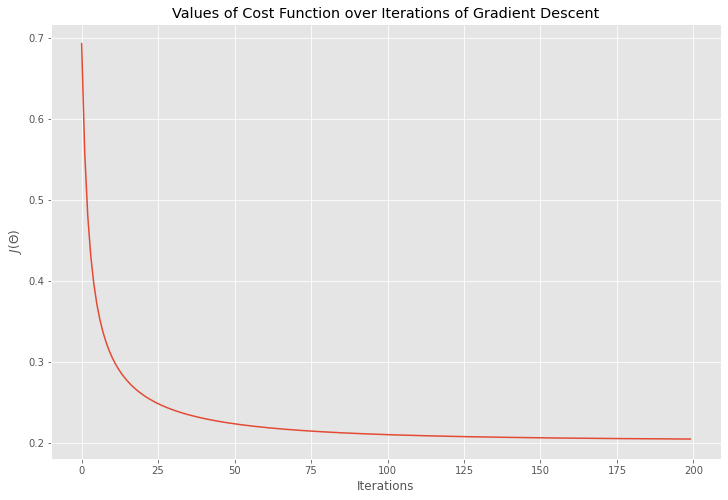

In [14]:
plt.plot(costs)
plt.xlabel("Iterations")
plt.ylabel("$J(\Theta)$")
plt.title("Values of Cost Function over Iterations of Gradient Descent");

We see that our cost function starts off at 0.693, really high, then there's a dramatic drop with every increase of gradient descent. And after a certain point, we see that the curve somewhere in 10th iterations in x-axis is asymptotic. And asymptotically approaches zero but never quite. They're diminishing returns once we increase the number of iterations after a certain points. Which is to say that after a certain number of run of gradient descents, our cost function is steadily minimized and approaches a global minimum.

So this is great. This is telling us that our gradient descent algorithm works. What we could do now in our next task is plot our data like we did in task 3, create a scatterplot of our data and over that, put in our decision boundary.

### Task 8: Plotting the decision boundary
---

$h_\theta(x) = \sigma(z)$, where $\sigma$ is the logistic sigmoid function and $z = \theta^Tx$

When $h_\theta(x) \geq 0.5$ the model predicts class "1":

$\implies \sigma(\theta^Tx) \geq 0.5$

$\implies \theta^Tx \geq 0$ predict class "1" 

Hence, $\theta_1 + \theta_2x_2 + \theta_3x_3 = 0$ is the equation for the decision boundary, giving us 

$ x_3 = \frac{-(\theta_1+\theta_2x_2)}{\theta_3}$

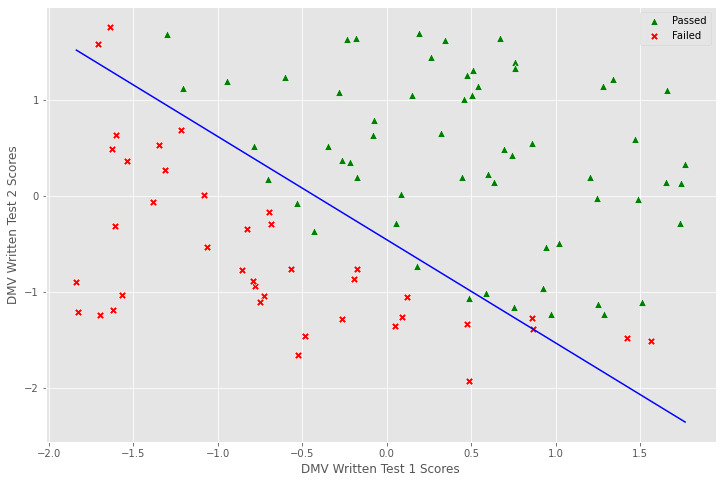

In [15]:
# copy the scatterplot from task 3
# we need to make some changes though.
# our matrix our no longer scores. It's X.
# So change scores to X.
# The indices have changed now. 0 changes to 1 and 1 changes to 2.
ax = sns.scatterplot(x = X[passed[:, 0], 1],
                     y = X[passed[:, 0], 2],
                     marker = "^",
                     color = 'green',
                     s=60)
sns.scatterplot(x = X[failed[:, 0], 1],
                y = X[failed[:, 0], 2],
                marker = "X",
                color = 'red',
                s=60)
# create a legend too
ax.legend(['Passed', 'Failed'])
ax.set(xlabel="DMV Written Test 1 Scores", ylabel="DMV Written Test 2 Scores")

# let's get to the meat of this task, which is plotting the decision boundary
x_boundary = np.array([np.min(X[:, 1]), np.max(X[:, 1])])
y_boundary = -(theta[0] + theta[1] * x_boundary) / theta[2]

# let's plot using seaborn line function
sns.lineplot(x=x_boundary, y=y_boundary, color="blue")
plt.show()

Great! We've got our lovely plot!
We have our data points as before. Our new edition here is our decision boundary from logistic model. We see that it is a linear decision boundary and it did a pretty good job at separating our data into passed and failed classes.
Of course this data is not perfectly linearly separable so we can see that we do have some misclassified points in both directions of this hyperplane.

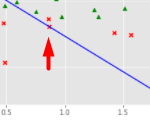 This point here is going to have a value of 0.5. So our model is very uncertain as to what class it belongs to.

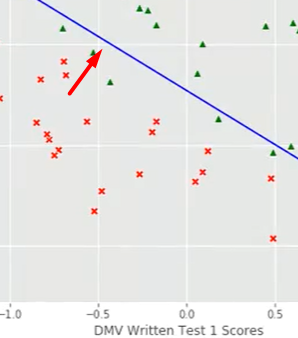
If we run more iterations of our gradient descent, we can move this line downwards towards the side of red data points so it will be closer to this point here 
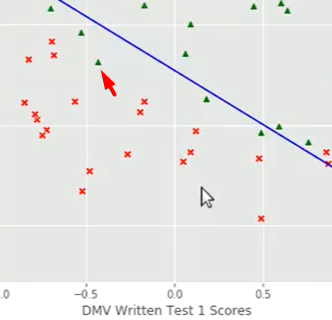. 

But nonetheless, our classifier did a very good job of separating these points. So now let's use the optimized theta values from our model in the next task to predict whether people with certain test scores has passed or failed their DMV test.

### Task 9: Predictions using the optimized $\theta$ values
---

$h_\theta(x) = x\theta$

Now that we have run our gradient descent algorithm to minimize the cost function of our stic regression model, we obtained the minimal values for our theta parameters, let's put these results and parameters to use by predicting the result for unseen data.

Performing predictions once we have the optimized theta values is extremely simple. We just take the dot product  of our inputs with the theta values.

In [16]:
# create a function that does this.
def predict(theta, x): # this function will take 2 values: theta and x
    results = logistic_function(x.dot(theta)) # the theta here is the optimized theta values 
                                              # that our model has already learned. 
                                              # So we dont have to compute theta over and over 
                                              # again once we run gradient descent the first time.
    return results > 0

What we can do is use this predict function to even find the accuracy of our model on the training set.

To find the accuracy of the classifier, we just compute the percentage of correct classification on our training set. And the function will simply return a boolean array with TRUE if the probability of passing the DMV is more than 0.5 and FALSE otherwise.

In [17]:
# Let's call the function predict
p = predict(theta, X)
print("Training Accuracy:", sum(p==y)[0], "%")
# y remember is our ground truth labels and we're just 
# counting the instances or fraction where our predicted values
# match up to the ground truth values.
# Then we're goona return the highest value [0] 
# followed by the percentage symbol.

Training Accuracy: 60 %


We see that we have a fair result of accuracy for 200 iterations of gradient descent. We get a 60% training accuracy. Our classifier is 60% of the time predicts correctly.

Let's use the optimize value to perform on unseen data.

In [18]:
# create synthetic value of test scores
test = np.array([50,79]) # we want to see if this person passes or fails the true test.
test = (test - mean_scores)/std_scores # center the data by dividing it by std
test = np.append(np.ones(1), test)
probability = logistic_function(test.dot(theta)) # this is what our predict function above does as well
print("A person who scores 50 and 79 on their DMV written tests have a",
      np.round(probability[0], 2),"probability of passing.")

A person who scores 50 and 79 on their DMV written tests have a 0.71 probability of passing.
